In [3]:
import pandas as pd


file_list = [
    
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_1_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_2_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_3_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_4_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_5_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_6_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_7_7.csv'
]

# 从CSV文件读取数据，并将日期列转换为datetime类型
df_list = [pd.read_csv(f, parse_dates=["IncorporationDate"]) for f in file_list]

# 合并所有数据框为一个大的数据框
df = pd.concat(df_list, ignore_index=True)
df.dropna(subset=['lat', 'long'], inplace=True)

# Save the processed dataframe to a new CSV file
#output_file_path = "/Users/rainfow/Desktop/Summer projects/companies_data/used_companies_data.csv"
#df.to_csv(output_file_path, index=False)


In [4]:
def filter_by_postcode_prefix(df, prefix):
    # Split the postcode at the space to get the prefix
    df['PostCodePrefix'] = df['RegAddress.PostCode'].str.split().str[0]
    # Filter the DataFrame based on the prefix
    df_filtered = df[df['PostCodePrefix'] == prefix]
    return df_filtered


In [5]:
df_filtered = filter_by_postcode_prefix(df, 'CF14')
df_filtered.head()

,CompanyName,RegAddress.PostCode,lat,long,CompanyCategory,IncorporationDate,SICCode.SicText_1,PostCodePrefix
299,&SPACE LTD,CF14 0XQ,51.534693,-3.179534,Private Limited Company,2022-04-11,62090 - Other information technology service a...,CF14
418,'SGWENNU LIMITED,CF14 6DH,51.518695,-3.211434,Private Limited Company,2015-04-21,90020 - Support activities to performing arts,CF14
440,'WEDDINGBOOKER.COM' LIMITED,CF14 3AY,51.501567,-3.203555,Private Limited Company,2018-04-24,90030 - Artistic creation,CF14
635,. LTD,CF14 8LH,51.522153,-3.194287,Private Limited Company,2018-04-12,63990 - Other information service activities n...,CF14
698,0'BRIEN'S MAINTENANCE LIMITED,CF14 4ST,51.523159,-3.204966,Private Limited Company,2022-07-04,41201 - Construction of commercial buildings,CF14


In [ ]:
num_unique_categories = df_filtered['RegAddress.PostCode'].nunique()

print(num_unique_categories)

In [6]:
import numpy as np

#df_filtered['Date'] = df_filtered['IncorporationDate'].dt.to_period('D')
df_filtered['Date'] = pd.to_datetime(df_filtered['IncorporationDate'])


##df_filtered_count = df_filtered.groupby(['RegAddress.PostCode', 'Date']).size().reset_index(name='CompanyCount')
##print(df_filtered_count.head(50))

df_filtered_count = df_filtered.groupby(['RegAddress.PostCode', 'Date']).agg({
    'CompanyName': lambda x: list(x),
    'lat': 'first',
    'long': 'first',
    'SICCode.SicText_1': lambda x: list(x),
}).reset_index()

# df_filtered_count['CompanyCount'] = df_filtered.groupby(['RegAddress.PostCode', 'Date']).size().values

df_filtered_count.head()


/var/folders/00/r2pslk7j4k158048921m90wm0000gn/T/ipykernel_2571/2322913796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['IncorporationDate'])


,RegAddress.PostCode,Date,CompanyName,lat,long,SICCode.SicText_1
0,CF14 0AB,2021-02-10,[BIFFY LTD],51.535540,-3.159611,[47910 - Retail sale via mail order houses or ...
1,CF14 0AD,2021-08-31,[MOORLYNCH LIMITED],51.545674,-3.166878,[98000 - Residents property management]
2,CF14 0AD,2022-08-26,[ST DENYS LIMITED],51.545674,-3.166878,[98000 - Residents property management]
3,CF14 0AF,1999-09-10,[ICHABOD'S INDUSTRIES LIMITED],51.536125,-3.159612,[69201 - Accounting and auditing activities]
4,CF14 0AF,2017-08-29,[SUPPLY CHAIN ASSOCIATES LIMITED],51.536125,-3.159612,"[74909 - Other professional, scientific and te..."


In [ ]:
df_filtered_count.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/df_filtered_count.csv', index=False)

In [ ]:
# Define a function to calculate the density score based on the fixed thresholds
def calculate_density_score(count):
    if count < 10:
        return 0
    elif count < 50:
        return 1
    elif count < 100:
        return 2
    else:
        return 3

# Calculate the company count per postcode
company_count_per_postcode = df_filtered_count.groupby('RegAddress.PostCode')['CompanyName'].count()

# Calculate the density score for each postcode
density_score = company_count_per_postcode.apply(calculate_density_score)

# Add the density score to the original dataframe
df_filtered_count = df_filtered_count.set_index('RegAddress.PostCode')
df_filtered_count['Density_Score'] = density_score
df_filtered_count = df_filtered_count.reset_index()

df_filtered_count.head(10)


In [ ]:
# Define a function to calculate the frequency score based on the fixed thresholds
from datetime import datetime

df_filtered_count['Date'] = df_filtered_count['Date'].dt.to_timestamp()

# Define the cutoff date
cutoff_date = datetime.strptime('2023-05-01', '%Y-%m-%d')

def Last_Registration_score(date):
    years = (cutoff_date - date).days / 365
    if years > 10:
        return 0
    elif years > 3:
        return 1
    else:
        return 2

# Calculate the date of the last company registration per postcode
last_registration_date_per_postcode = df_filtered_count.groupby('RegAddress.PostCode')['Date'].max()

# Calculate the frequency score for each postcode
frequency_score = last_registration_date_per_postcode.apply(Last_Registration_score)

# Add the frequency score to the original dataframe
df_filtered_count = df_filtered_count.set_index('RegAddress.PostCode')
df_filtered_count['Last_Registration_score'] = frequency_score
df_filtered_count = df_filtered_count.reset_index()

df_filtered_count.head()


In [ ]:

# Calculate the date of the first and last company registration per postcode
first_registration_date_per_postcode = df_filtered_count.groupby('RegAddress.PostCode')['Date'].min()
last_registration_date_per_postcode = df_filtered_count.groupby('RegAddress.PostCode')['Date'].max()

# Define a function to calculate the registration span score based on the fixed thresholds
def Registration_Span_Score(span):
    if span == 0 or span > 20:
        return 0
    elif span > 6:
        return 1
    elif span > 1:
        return 2
    else:
        return 3

# Calculate the registration span in years for each postcode
registration_span_per_postcode = (last_registration_date_per_postcode - first_registration_date_per_postcode).dt.days / 365

# Calculate the registration span score for each postcode
registration_span_score = registration_span_per_postcode.apply(Registration_Span_Score)

# Add the registration span score to the original dataframe
df_filtered_count = df_filtered_count.set_index('RegAddress.PostCode')
df_filtered_count['Registration_Span_Score'] = registration_span_score
df_filtered_count = df_filtered_count.reset_index()

df_filtered_count.head()


In [ ]:

# Define a function to calculate the frequency score based on the fixed thresholds
def calculate_frequency_score(group):
    if len(group) < 3:
        return 0
    counts = group['Date'].value_counts()
    max_count = counts.max()
    if max_count < 5:
        return 1
    elif max_count < 10:
        return 2
    else:
        return 3

# Group by the postcode and calculate the frequency score for each postcode
frequency_score = df_filtered_count.groupby('RegAddress.PostCode').apply(calculate_frequency_score)

# Add the frequency score to the original dataframe
df_filtered_count = df_filtered_count.set_index('RegAddress.PostCode')
df_filtered_count['FrequencyScore'] = frequency_score
df_filtered_count = df_filtered_count.reset_index()

df_filtered_count.head()


In [ ]:
# Modify the function to correct the calculation of the registration span score
def calculate_scores(df_filtered_count):
    # Convert 'Date' column to datetime format
    df_filtered_count['Date'] = df_filtered_count['Date'].dt.to_timestamp()

    # Define a function to calculate the density score
    def calculate_density_score(count):
        if count < 10:
            return 0
        elif count < 50:
            return 1
        elif count < 100:
            return 2
        else:
            return 3

    # Calculate the company count per postcode
    company_count_per_postcode = df_filtered_count.groupby('RegAddress.PostCode')['CompanyName'].count()

    # Calculate the density score for each postcode
    density_score = company_count_per_postcode.apply(calculate_density_score)

    # Define the cutoff date
    cutoff_date = datetime.strptime('2023-05-01', '%Y-%m-%d')

    # Define a function to calculate the last registration score
    def Last_Registration_score(date):
        years = (cutoff_date - date).days / 365
        if years > 10:
            return 0
        elif years > 3:
            return 1
        else:
            return 2

    # Calculate the date of the last company registration per postcode
    last_registration_date_per_postcode = df_filtered_count.groupby('RegAddress.PostCode')['Date'].max()

    # Calculate the last registration score for each postcode
    last_registration_score = last_registration_date_per_postcode.apply(Last_Registration_score)

    # Define a function to calculate the registration span score
    def Registration_Span_Score(group):
        span = (group.max() - group.min()).days / 365
        if span == 0 or span > 20:
            return 0
        elif span > 6:
            return 1
        elif span > 1:
            return 2
        else:
            return 3

    # Calculate the registration span score for each postcode
    registration_span_score = df_filtered_count.groupby('RegAddress.PostCode')['Date'].apply(Registration_Span_Score)

    # Define a function to calculate the frequency score
    def calculate_frequency_score(group):
        if len(group) < 3:
            return 0
        counts = group['Date'].value_counts()
        max_count = counts.max()
        if max_count < 5:
            return 1
        elif max_count < 10:
            return 2
        else:
            return 3

    # Calculate the frequency score for each postcode
    frequency_score = df_filtered_count.groupby('RegAddress.PostCode').apply(calculate_frequency_score)

    # Create a new dataframe to hold the scores
    df_scores = df_filtered_count.copy()
    df_scores['CompanyCount'] = df_scores.groupby('RegAddress.PostCode')['CompanyName'].transform('count')
    df_scores['Density_Score'] = df_scores['RegAddress.PostCode'].map(density_score)
    df_scores['LastRegistration_Score'] = df_scores['RegAddress.PostCode'].map(last_registration_score)
    df_scores['RegistrationSpan_Score'] = df_scores['RegAddress.PostCode'].map(registration_span_score)
    df_scores['Frequency_Score'] = df_scores['RegAddress.PostCode'].map(frequency_score)

    return df_scores

# Test the function

df_filtered_scores = calculate_scores(df_filtered_count)
df_filtered_scores.head()


In [7]:
from datetime import datetime

def calculate_scores(df_filtered_count):
    # Ensure 'Date' column is in datetime format
    df_filtered_count['Date'] = pd.to_datetime(df_filtered_count['Date'])

    # Calculate the company count per postcode and date
    company_count_per_postcode_and_date = df_filtered_count.groupby(['RegAddress.PostCode', 'Date']).apply(lambda group: len(group['CompanyName'].explode()))

    # Define a function to calculate the density score
    def calculate_density_score(group):
        count = len(group['CompanyName'].explode())
        if count < 10:
            return 0
        elif count < 50:
            return 1
        elif count < 100:
            return 2
        else:
            return 3

    # Calculate the density score for each postcode
    density_score = df_filtered_count.groupby('RegAddress.PostCode').apply(calculate_density_score)

    # Define the cutoff date
    cutoff_date = datetime.strptime('2023-05-01', '%Y-%m-%d')

    # Define a function to calculate the last registration score
    def Last_Registration_score(date):
        years = (cutoff_date - date).days / 365
        if years > 10:
            return 0
        elif years > 3:
            return 1
        elif years > 1:
            return 2
        else:
            return 3

    # Calculate the date of the last company registration per postcode
    last_registration_date_per_postcode = df_filtered_count.groupby('RegAddress.PostCode')['Date'].max()

    # Calculate the last registration score for each postcode
    last_registration_score = last_registration_date_per_postcode.apply(Last_Registration_score)

    # Define a function to calculate the registration span score
    def Registration_Span_Score(group):
        span = (group.max() - group.min()).days / 365
        if span == 0 or span > 20:
            return 0
        elif span > 6:
            return 1
        elif span > 1:
            return 2
        else:
            return 3

    # Calculate the registration span score for each postcode
    registration_span_score = df_filtered_count.groupby('RegAddress.PostCode')['Date'].apply(Registration_Span_Score)

    # Define a function to calculate the frequency score
    def calculate_frequency_score(group):
        max_count = group.max()
        if max_count < 3:
            return 0
        elif max_count < 5:
            return 1
        elif max_count < 10:
            return 2
        else:
            return 3

    # Calculate the frequency score for each postcode
    frequency_score = company_count_per_postcode_and_date.groupby('RegAddress.PostCode').apply(calculate_frequency_score)

    # Create a new dataframe to hold the scores
    df_scores = df_filtered_count.copy()
    df_scores['CompanyCount'] = df_scores.set_index(['RegAddress.PostCode', 'Date']).index.map(company_count_per_postcode_and_date)
    df_scores['Density_Score'] = df_scores['RegAddress.PostCode'].map(density_score)
    df_scores['LastRegistration_Score'] = df_scores['RegAddress.PostCode'].map(last_registration_score)
    df_scores['RegistrationSpan_Score'] = df_scores['RegAddress.PostCode'].map(registration_span_score)
    df_scores['Frequency_Score'] = df_scores['RegAddress.PostCode'].map(frequency_score)

    return df_scores

# Test the function
df_filtered_scores = calculate_scores(df_filtered_count)
df_filtered_scores.head()


,RegAddress.PostCode,Date,CompanyName,lat,long,SICCode.SicText_1,CompanyCount,Density_Score,LastRegistration_Score,RegistrationSpan_Score,Frequency_Score
0,CF14 0AB,2021-02-10,[BIFFY LTD],51.535540,-3.159611,[47910 - Retail sale via mail order houses or ...,1,0,2,0,0
1,CF14 0AD,2021-08-31,[MOORLYNCH LIMITED],51.545674,-3.166878,[98000 - Residents property management],1,0,3,3,0
2,CF14 0AD,2022-08-26,[ST DENYS LIMITED],51.545674,-3.166878,[98000 - Residents property management],1,0,3,3,0
3,CF14 0AF,1999-09-10,[ICHABOD'S INDUSTRIES LIMITED],51.536125,-3.159612,[69201 - Accounting and auditing activities],1,0,1,1,0
4,CF14 0AF,2017-08-29,[SUPPLY CHAIN ASSOCIATES LIMITED],51.536125,-3.159612,"[74909 - Other professional, scientific and te...",1,0,1,1,0


In [ ]:
df_filtered_scores.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/df_filtered_scores.csv', index=False)

In [8]:
# Calculate the sum of all scores for each postcode directly in the df_filtered_scores dataframe
df_filtered_scores['SumScores'] = df_filtered_scores[['Density_Score', 'LastRegistration_Score', 'RegistrationSpan_Score', 'Frequency_Score']].sum(axis=1)

# Group by postcode and calculate the max of sum of scores for each postcode
df_scores_sum = df_filtered_scores.groupby('RegAddress.PostCode').agg(
    lat=('lat', 'first'),  # Use the first latitude value for each postcode
    long=('long', 'first'),  # Use the first longitude value for each postcode
    TotalCompany=('CompanyName', 'size'),  # Count the total number of companies
    SumScores=('SumScores', 'max')  # Calculate the max of sum of scores
)

df_scores_sum_reset = df_scores_sum.reset_index()
df_scores_sum_reset


,RegAddress.PostCode,lat,long,TotalCompany,SumScores
0,CF14 0AB,51.535540,-3.159611,1,2
1,CF14 0AD,51.545674,-3.166878,2,6
2,CF14 0AF,51.536125,-3.159612,2,2
3,CF14 0AH,51.536829,-3.170213,2,3
4,CF14 0AN,51.538160,-3.164782,1,3
...,...,...,...,...,...
1016,CF14 9JL,51.544252,-3.196351,1,2
1017,CF14 9UA,51.542923,-3.208487,3,2
1018,CF14 9UB,51.548160,-3.204602,2,2
1019,CF14 9UD,51.550145,-3.195193,1,1


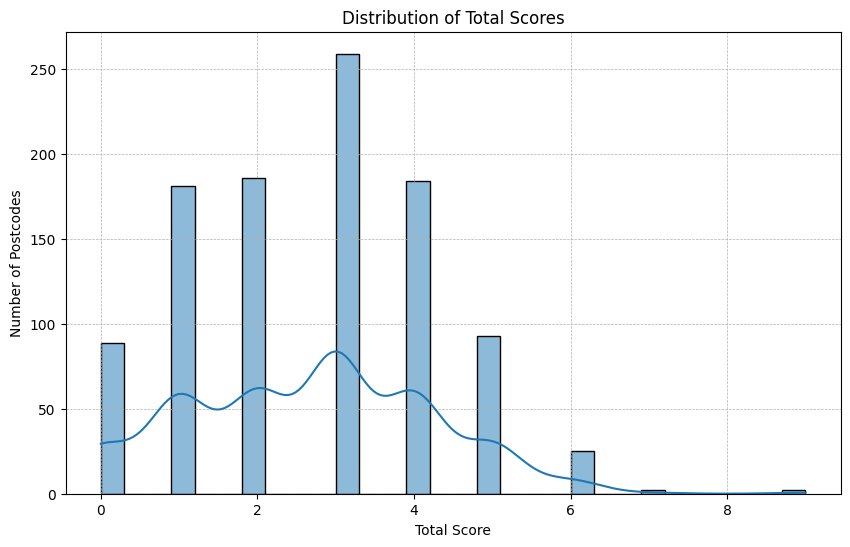

count    1021.000000
mean        2.657199
std         1.558034
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max         9.000000
Name: SumScores, dtype: float64

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistical description of Total_Score
score_description = df_scores_sum_reset["SumScores"].describe()

# Plot the histogram for Total_Score
plt.figure(figsize=(10,6))
sns.histplot(df_scores_sum_reset["SumScores"], kde=True, bins=30)
plt.title("Distribution of Total Scores")
plt.xlabel("Total Score")
plt.ylabel("Number of Postcodes")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

score_description


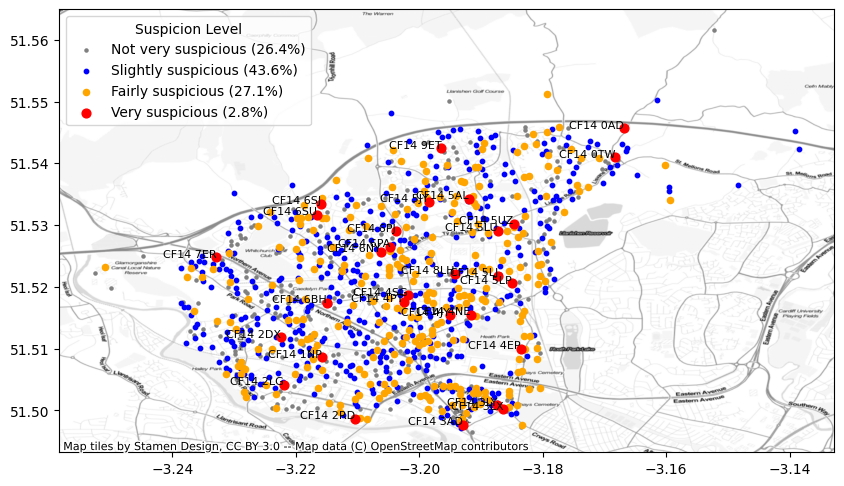

In [10]:
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))


# Define the color and size mapping based on the quantiles of 'SumScores'
def map_color_size(score):

    threshold_1 = 5

    if score <= df_scores_sum_reset['SumScores'].quantile(0.25):
        return 'gray', 5, 'Not very suspicious'
    elif score <= df_scores_sum_reset['SumScores'].quantile(0.50):
        return 'blue', 10, 'Slightly suspicious'
    elif score <= threshold_1:
        return 'orange', 20, 'Fairly suspicious'
    else:
        return 'red', 40, 'Very suspicious'

df_scores_sum_reset['color'], df_scores_sum_reset['size'], df_scores_sum_reset['label'] = zip(*df_scores_sum_reset['SumScores'].apply(map_color_size))

# Calculate the total number of postcodes
total_postcodes = len(df_scores_sum_reset)

# Define a dictionary for labels, colors, and sizes
label_dict = {
    'Not very suspicious': {'color': 'gray', 'size': 5},
    'Slightly suspicious': {'color': 'blue', 'size': 10},
    'Fairly suspicious': {'color': 'orange', 'size': 20},
    'Very suspicious': {'color': 'red', 'size': 40}
}

# Scatter plot
for label, attr in label_dict.items():
    idx = df_scores_sum_reset['label'] == label
    postcode_count = len(df_scores_sum_reset.loc[idx])
    percentage = postcode_count / total_postcodes * 100
    ax.scatter(df_scores_sum_reset.loc[idx, 'long'], df_scores_sum_reset.loc[idx, 'lat'], c=attr['color'], s=attr['size'], label=f'{label} ({percentage:.1f}%)')

    if label == "Very suspicious":
        for x, y, postcode in zip(df_scores_sum_reset.loc[idx, 'long'], df_scores_sum_reset.loc[idx, 'lat'], df_scores_sum_reset.loc[idx, 'RegAddress.PostCode']):
            ax.text(x, y, postcode, ha='right', fontsize=8, color='black')

# Add legend
ax.legend(title="Suspicion Level")

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Show the plot
plt.show()


In [ ]:
# df_scores_sum_reset.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/df_scores_sum_reset.csv', index=False)

# hdbscan clustering --------------------------------

In [ ]:
import hdbscan

df_hdbscan_2d = df_scores_sum_reset.copy()

# Prepare the data
data = df_hdbscan_2d[['lat', 'long']].values

# Create the HDBSCAN model
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)

# min_samples 和 cluster_selection_epsilon 参数可调整

# Fit the model
clusterer.fit(data)

# Get the labels
labels = clusterer.labels_

# Add the cluster labels to the dataframe
df_hdbscan_2d['cluster'] = labels

df_hdbscan_2d.head()


In [ ]:
df_scores_sum_reset.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/df_scores_sum_reset.csv', index=False)

In [ ]:
# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define a color map
cmap = plt.get_cmap('tab20')

# Get the number of clusters (excluding noise points)
n_clusters = len([c for c in np.unique(labels) if c != -1])

# Scatter plot
for i in np.unique(df_hdbscan_2d['cluster']):
    if i == -1:  # noise points in DBSCAN are labeled as -1
        color = 'gray'
        marker = '^'  # using triangle marker for noise points
    else:
        color = cmap(i % 20)  # use modulo 20 to ensure the color index is within the range of the color map
        marker = 's'
    idx = df_hdbscan_2d['cluster'] == i
    ax.scatter(df_hdbscan_2d.loc[idx, 'long'], df_hdbscan_2d.loc[idx, 'lat'], 
               color=color, label=f"Cluster {i}", marker=marker)

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Add legend
ax.legend()

# Show the plot
plt.show()


In [ ]:

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define a color map
cmap = plt.get_cmap('tab20')

# Get the number of clusters (excluding noise points)
n_clusters = len([c for c in np.unique(labels) if c != -1])
# Group by cluster and calculate the mean score for each cluster
cluster_avg_scores = df_hdbscan_2d.groupby('cluster')['SumScores'].mean()

# Check if there are noise points
if -1 in cluster_avg_scores.index:
    noise_avg_score = cluster_avg_scores[-1]
else:
    noise_avg_score = None

# Scatter plot
for i in np.unique(df_hdbscan_2d['cluster']):
    if i == -1:  # noise points in DBSCAN are labeled as -1
        color = 'gray'
        marker = '^'  # using triangle marker for noise points
    else:
        color = cmap(i % 20)  # use modulo 20 to ensure the color index is within the range of the color map
        # Use a square marker for clusters with an average score higher than the noise points
        marker = 's' if noise_avg_score and cluster_avg_scores[i] > noise_avg_score else '^'
    idx = df_hdbscan_2d['cluster'] == i
    ax.scatter(df_hdbscan_2d.loc[idx, 'long'], df_hdbscan_2d.loc[idx, 'lat'], 
               color=color, label=f"Cluster {i}, Avg Score: {cluster_avg_scores[i]:.2f}", marker=marker)
    
    # Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Add legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
# Now, let's visualize the clustering results with different markers for noise points and clusters with average scores higher than the noise points
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot with different markers and new color map
for i in np.unique(df_hdbscan_2d['cluster']):
    if i == -1:  # noise points in DBSCAN are labeled as -1
        color = 'gray'
        marker = '^'  # using triangle marker for noise points
    else:
        color = cmap(i % 20)  # use modulo 20 to ensure the color index is within the range of the color map
        # Use a square marker for clusters with an average score higher than the noise points
        marker = 's' if noise_avg_score and cluster_avg_scores[i] > noise_avg_score else '^'
    idx = df_hdbscan_2d['cluster'] == i
    ax.scatter(df_hdbscan_2d.loc[idx, 'long'], df_hdbscan_2d.loc[idx, 'lat'], 
               color=color, label=f"Cluster {i}, Avg Score: {cluster_avg_scores[i]:.2f}", marker=marker)

# Annotate the postcodes with a score higher than 6
high_score_points = df_hdbscan_2d[df_hdbscan_2d['SumScores'] >= 6]
for _, row in high_score_points.iterrows():
    ax.annotate(row['RegAddress.PostCode'],
                (row['long'], row['lat']),
                textcoords="offset points", xytext=(-15,10), ha='center', fontsize=8, color='black', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))
    
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Add legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
# Identify clusters with an average score higher than the noise points
high_score_clusters = [i for i in np.unique(df_hdbscan_2d['cluster']) if i != -1]

# Count the number of high score points in these clusters
num_high_score_points_in_high_score_clusters = high_score_points['cluster'].isin(high_score_clusters).sum()

# Calculate the proportion
proportion = num_high_score_points_in_high_score_clusters / len(high_score_points)

num_high_score_points_in_high_score_clusters, proportion


In [ ]:
df_scores_sum_reset.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/df_hdbscan_3d.csv', index=False)

In [101]:
import pandas as pd
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

df_hdbscan_3d = df_scores_sum_reset.copy()

# Prepare the data with three dimensions: latitude, longitude, and SumScores
data_3d = df_hdbscan_3d[['lat', 'long', 'SumScores']].values

# Standardize the data
scaler = StandardScaler()
data_3d_scaled = scaler.fit_transform(data_3d)

# Create the HDBSCAN model with the same parameters
clusterer_3d = hdbscan.HDBSCAN(min_cluster_size=18, gen_min_span_tree=True)

# Fit the model with the three-dimensional standardized data
clusterer_3d.fit(data_3d_scaled)

# Get the labels
labels_3d = clusterer_3d.labels_

# Add the cluster labels to the dataframe
df_hdbscan_3d['cluster_3d'] = labels_3d

# Save or view the result
df_hdbscan_3d.head()


,RegAddress.PostCode,lat,long,TotalCompany,SumScores,color,size,label,cluster_3d
0,CF14 0AB,51.535540,-3.159611,1,2,blue,10,Slightly suspicious,-1
1,CF14 0AD,51.545674,-3.166878,2,6,red,40,Very suspicious,-1
2,CF14 0AF,51.536125,-3.159612,2,2,blue,10,Slightly suspicious,-1
3,CF14 0AH,51.536829,-3.170213,2,3,blue,10,Slightly suspicious,-1
4,CF14 0AN,51.538160,-3.164782,1,3,blue,10,Slightly suspicious,-1


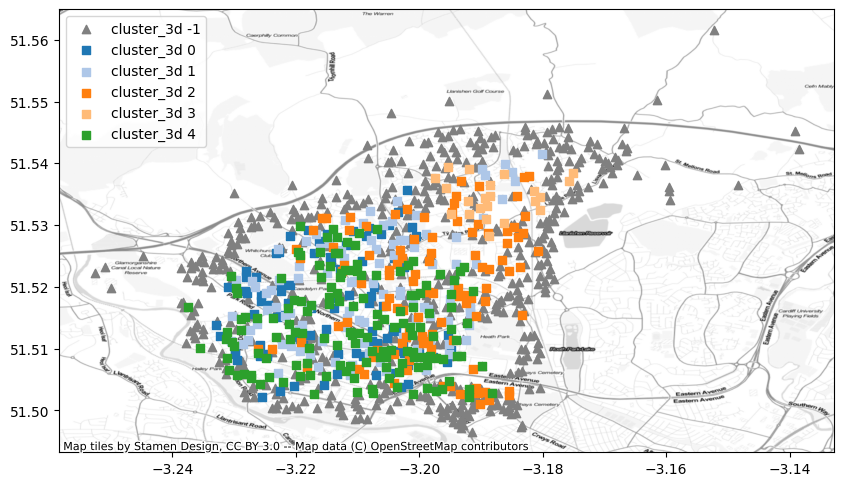

In [102]:
# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define a color map
cmap = plt.get_cmap('tab20')

# Get the number of clusters (excluding noise points)
n_clusters = len([c for c in np.unique(labels_3d) if c != -1])

# Scatter plot
for i in np.unique(df_hdbscan_3d['cluster_3d']):
    if i == -1:  # noise points in DBSCAN are labeled as -1
        color = 'gray'
        marker = '^'  # using triangle marker for noise points
    else:
        color = cmap(i % 20)  # use modulo 20 to ensure the color index is within the range of the color map
        marker = 's'
    idx = df_hdbscan_3d['cluster_3d'] == i
    ax.scatter(df_hdbscan_3d.loc[idx, 'long'], df_hdbscan_3d.loc[idx, 'lat'], 
               color=color, label=f"cluster_3d {i}", marker=marker)

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Add legend
ax.legend()

# Show the plot
plt.show()


# dbscan clustering ------------------------------------

In [35]:
from sklearn.cluster import DBSCAN

# Prepare the data
df_dbscan = df_scores_sum_reset

data_dbscan = df_dbscan[['lat', 'long', 'SumScores']].values

# Create the DBSCAN model
dbscan = DBSCAN(min_samples=20)  # you can adjust these parameters based on your needs

# Fit the model and get the labels
labels = dbscan.fit_predict(data_dbscan)

# Add the cluster labels to the dataframe
df_dbscan['cluster'] = labels

df_dbscan.head()

,RegAddress.PostCode,lat,long,TotalCompany,SumScores,color,size,label,cluster
0,CF14 0AB,51.535540,-3.159611,1,2,blue,10,Slightly suspicious,0
1,CF14 0AD,51.545674,-3.166878,2,6,red,40,Very suspicious,1
2,CF14 0AF,51.536125,-3.159612,2,2,blue,10,Slightly suspicious,0
3,CF14 0AH,51.536829,-3.170213,2,3,blue,10,Slightly suspicious,2
4,CF14 0AN,51.538160,-3.164782,1,3,blue,10,Slightly suspicious,2


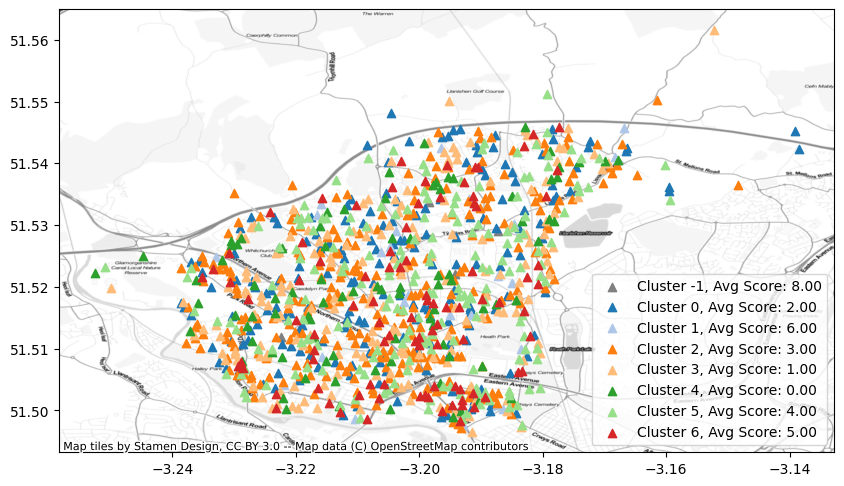

In [36]:

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define a color map
cmap = plt.get_cmap('tab20')

# Get the number of clusters (excluding noise points)
n_clusters = len([c for c in np.unique(labels) if c != -1])
# Group by cluster and calculate the mean score for each cluster
cluster_avg_scores = df_dbscan.groupby('cluster')['SumScores'].mean()

# Check if there are noise points
if -1 in cluster_avg_scores.index:
    noise_avg_score = cluster_avg_scores[-1]
else:
    noise_avg_score = None

# Scatter plot
for i in np.unique(df_dbscan['cluster']):
    if i == -1:  # noise points in DBSCAN are labeled as -1
        color = 'gray'
        marker = '^'  # using triangle marker for noise points
    else:
        color = cmap(i % 20)  # use modulo 20 to ensure the color index is within the range of the color map
        # Use a square marker for clusters with an average score higher than the noise points
        marker = 's' if noise_avg_score and cluster_avg_scores[i] > noise_avg_score else '^'
    idx = df_dbscan['cluster'] == i
    ax.scatter(df_dbscan.loc[idx, 'long'], df_dbscan.loc[idx, 'lat'], 
               color=color, label=f"Cluster {i}, Avg Score: {cluster_avg_scores[i]:.2f}", marker=marker)
    
    # Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Add legend
ax.legend()

# Show the plot
plt.show()


# KMeans Clustering --------------------------

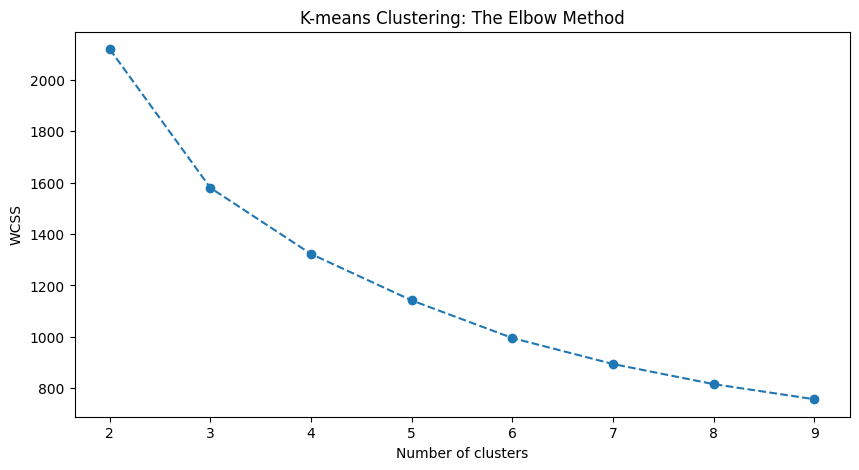

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df_kmeans_3d = df_scores_sum_reset.copy()

# Prepare the data with three dimensions: latitude, longitude, and SumScores
data_3d = df_kmeans_3d[['lat', 'long', 'SumScores']].values

# Standardize the data
scaler = StandardScaler()
data_3d_scaled = scaler.fit_transform(data_3d)

# Use the Elbow method to find a good number of clusters using WCSS (Within-Cluster-Sum-of-Squares)
wcss = []

# Checking for up to 10 clusters
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10, max_iter=300, algorithm='elkan')
    kmeans.fit(data_3d_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method
plt.figure(figsize=(10,5))
plt.plot(range(2, 10), wcss, marker='o', linestyle='--')
plt.title('K-means Clustering: The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [20]:
# Assuming 'n' is the optimal number of clusters after observing the plot
#n = int(input("Enter the optimal number of clusters (based on the Elbow plot): "))

kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42,algorithm='elkan')
labels_kmeans = kmeans.fit_predict(data_3d_scaled)

# Add the cluster labels to the dataframe
df_kmeans_3d['cluster_kmeans'] = labels_kmeans

# Save or view the result
df_kmeans_3d.head()

/Users/rainfow/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,RegAddress.PostCode,lat,long,TotalCompany,SumScores,color,size,label,cluster_kmeans
0,CF14 0AB,51.535540,-3.159611,1,2,blue,10,Slightly suspicious,1
1,CF14 0AD,51.545674,-3.166878,2,6,red,40,Very suspicious,1
2,CF14 0AF,51.536125,-3.159612,2,2,blue,10,Slightly suspicious,1
3,CF14 0AH,51.536829,-3.170213,2,3,blue,10,Slightly suspicious,1
4,CF14 0AN,51.538160,-3.164782,1,3,blue,10,Slightly suspicious,1


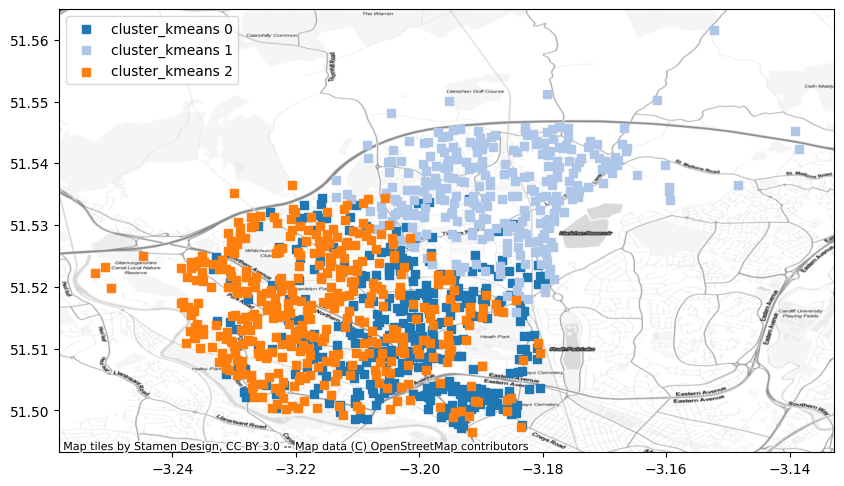

In [22]:
# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define a color map
cmap = plt.get_cmap('tab20')

# Get the number of clusters (excluding noise points)
n_clusters = len([c for c in np.unique(labels_kmeans) if c != -1])

# Scatter plot
for i in np.unique(df_kmeans_3d['cluster_kmeans']):
    if i == -1:  # noise points in DBSCAN are labeled as -1
        color = 'gray'
        marker = '^'  # using triangle marker for noise points
    else:
        color = cmap(i % 20)  # use modulo 20 to ensure the color index is within the range of the color map
        marker = 's'
    idx = df_kmeans_3d['cluster_kmeans'] == i
    ax.scatter(df_kmeans_3d.loc[idx, 'long'], df_kmeans_3d.loc[idx, 'lat'], 
               color=color, label=f"cluster_kmeans {i}", marker=marker)

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Add legend
ax.legend()

# Show the plot
plt.show()
